In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pylab as pl
import shapely
import os
import statsmodels as stm
#import urllib2
import urllib
#import StringIO
import ast
from datetime import datetime, timedelta
import time
import io
import json
import requests
import shutil
import datetime as dt
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
from sklearn import preprocessing
import statsmodels.formula.api as smf
import pytz as pytz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


---

# WEATHER

In [2]:
# Downloadind the weather data - don't run again
#!unzip "DarkSky_Data.zip"

In [3]:
# Reading in the weather 

weather = pd.read_json("DarkSky_Data.json")

In [4]:
weather.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed
0,26.80,0.82,28.43,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1009.73,Mostly Cloudy,32.48,1136091600,8.84,335.0,6.00
1,27.04,0.77,28.32,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1010.35,Mostly Cloudy,32.33,1136095200,7.67,345.0,5.49
2,27.21,0.78,28.34,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1011.40,Mostly Cloudy,32.29,1136098800,8.69,344.0,5.23
3,27.01,0.34,27.97,0.84,partly-cloudy-night,NaN,0.0,0.0,NaN,1012.17,Partly Cloudy,32.19,1136102400,8.79,345.0,5.32
4,26.65,0.95,28.10,0.85,cloudy,NaN,0.0,0.0,NaN,1012.67,Overcast,32.00,1136106000,8.41,339.0,5.49


In [5]:
# # Adding datetime column to weather data

weather['datetime'] = pd.to_datetime(weather['time'], unit='s', utc=True)

In [6]:
# Adjusting the datetime for timezone 

tz = pytz.timezone('America/New_York')

adjustDateTime = []
for i in range(len(weather)):
    adjustDateTime.append(weather['datetime'][i].tz_localize(pytz.utc).tz_convert(tz).tz_localize(None))

In [7]:
# Adding the adjusted column

weather['datetime_adj'] = adjustDateTime

In [8]:
# Reweather.head()

In [9]:
# Removing duplicated rows

weather = weather.drop_duplicates(subset=['datetime_adj'])

---

# CRIME

In [10]:
## Downloading the crime data -- very large, don't run again

#!wget "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"

In [11]:
# Reading in the crime data

crimeData = pd.read_csv("rows.csv_accessType=DOWNLOAD")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
# Looking through the columns

crimeData.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon'],
      dtype='object')

In [13]:
crimeData.PREM_TYP_DESC.unique()

array(['BAR/NIGHT CLUB', nan, 'OTHER', 'RESIDENCE-HOUSE', 'DRUG STORE',
       'STREET', 'RESIDENCE - APT. HOUSE', 'FAST FOOD', 'RESTAURANT/DINER',
       'DRY CLEANER/LAUNDRY', 'PUBLIC BUILDING',
       'RESIDENCE - PUBLIC HOUSING', 'PARK/PLAYGROUND',
       'PARKING LOT/GARAGE (PUBLIC)', 'GAS STATION', 'TUNNEL',
       'CHAIN STORE', 'CHECK CASHING BUSINESS', 'TRANSIT - NYC SUBWAY',
       'BUS (NYC TRANSIT)', 'BEAUTY & NAIL SALON', 'GROCERY/BODEGA',
       'COMMERCIAL BUILDING', 'FOOD SUPERMARKET', 'HOTEL/MOTEL',
       'SMALL MERCHANT', 'CHURCH', 'PARKING LOT/GARAGE (PRIVATE)',
       'DEPARTMENT STORE', 'STORE UNCLASSIFIED', 'GYM/FITNESS FACILITY',
       'VARIETY STORE', 'CLOTHING/BOUTIQUE', 'FERRY/FERRY TERMINAL',
       'DOCTOR/DENTIST OFFICE', 'TELECOMM. STORE', 'JEWELRY',
       'CONSTRUCTION SITE', 'BUS STOP', 'BANK', 'HOSPITAL',
       'TAXI (LIVERY LICENSED)', 'ATM', 'BRIDGE',
       'PRIVATE/PAROCHIAL SCHOOL', 'SOCIAL CLUB/POLICY', 'CANDY STORE',
       'FACTORY/WAREHOUSE

In [14]:
crimeData.PREM_TYP_DESC.value_counts()

STREET                          1841239
RESIDENCE - APT. HOUSE          1158315
RESIDENCE-HOUSE                  549568
RESIDENCE - PUBLIC HOUSING       419936
OTHER                            148410
COMMERCIAL BUILDING              144019
TRANSIT - NYC SUBWAY             117859
DEPARTMENT STORE                 107343
CHAIN STORE                      107217
PUBLIC SCHOOL                     71369
PARK/PLAYGROUND                   66910
GROCERY/BODEGA                    63868
RESTAURANT/DINER                  62655
BAR/NIGHT CLUB                    62573
CLOTHING/BOUTIQUE                 46040
DRUG STORE                        42202
PUBLIC BUILDING                   35437
PARKING LOT/GARAGE (PUBLIC)       32031
PARKING LOT/GARAGE (PRIVATE)      31617
FOOD SUPERMARKET                  29703
HOSPITAL                          26064
STORE UNCLASSIFIED                25614
FAST FOOD                         25516
SMALL MERCHANT                    23747
BANK                              23412


In [15]:
crimeData.tail()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
5580030,582350583,01/01/2015,03:50:00,01/01/2016,04:00:00,01/01/2016,105,ROBBERY,399.0,"ROBBERY,COMMERCIAL UNCLASSIFIED",...,30.0,INSIDE,HOTEL/MOTEL,NaN,NaN,998372.0,240146.0,40.825818,-73.948975,"(40.825817778, -73.948974825)"
5580031,258046495,01/01/2015,01:25:00,01/01/2016,01:30:00,01/01/2016,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",...,41.0,NaN,TRANSIT - NYC SUBWAY,NaN,NaN,1014468.0,238156.0,40.820315,-73.890825,"(40.820315396, -73.890824603)"
5580032,640212578,01/01/2015,00:30:00,01/01/2016,00:40:00,01/01/2016,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",...,109.0,FRONT OF,BAR/NIGHT CLUB,NaN,NaN,1030529.0,214093.0,40.754199,-73.832963,"(40.754199468, -73.832962523)"
5580033,496500431,06/30/2014,12:00:00,12/29/2015,12:00:00,01/01/2016,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,...,50.0,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1009735.0,261272.0,40.883777,-73.907837,"(40.883776851, -73.907836928)"
5580034,256379572,12/31/2001,16:00:00,01/01/2016,10:50:00,01/01/2016,107,BURGLARY,213.0,"BURGLARY,COMMERCIAL,NIGHT",...,84.0,INSIDE,PUBLIC SCHOOL,NaN,NaN,989682.0,188334.0,40.683617,-73.980416,"(40.683616638, -73.980416007)"


In [16]:
# Filtering down to complaint dates between 01/01/2006 - 12/31/2017

crimeData['year'] = crimeData['CMPLNT_FR_DT'].str[-4:].fillna(0).astype(int)
crimeData['hour'] = crimeData['CMPLNT_FR_TM'].str[:2].fillna(0).astype(int)
crime = crimeData[((crimeData['year'] > 2005) & (crimeData['hour'] < 24))]

# Creating datetime column

crime['datetime'] = pd.to_datetime((crime['CMPLNT_FR_DT'] + ' ' + crime['CMPLNT_FR_TM']), format='%m/%d/%Y %H:%M:%S')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# dropping NaNs from datetime

crime = crime.dropna(axis=0, subset=['datetime'])
crime = crime.reset_index()

In [18]:
# Rounding to the nearest hour

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

crimeRound = []

for i in range(len(crime)):
     t = crime['datetime'][i]
     crimeRound.append(hour_rounder(t)) 

In [19]:
# Adding the rounded datetime to the dataframe

crime['datetime_round'] = crimeRound

In [20]:
crime.head()

,index,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,year,hour,datetime,datetime_round
0,0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,...,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)",2015,23,2015-12-31 23:45:00,2016-01-01 00:00:00
1,1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)",2015,23,2015-12-31 23:36:00,2016-01-01 00:00:00
2,2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,...,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)",2015,23,2015-12-31 23:30:00,2016-01-01 00:00:00
3,3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)",2015,23,2015-12-31 23:30:00,2016-01-01 00:00:00
4,4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)",2015,23,2015-12-31 23:25:00,2015-12-31 23:00:00


In [21]:
# Unique crime types

crimeData.OFNS_DESC.unique()

array(['FORGERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'DANGEROUS DRUGS',
       'ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT',
       'DANGEROUS WEAPONS', 'PETIT LARCENY', 'GRAND LARCENY', 'ROBBERY',
       'OFFENSES AGAINST PUBLIC ADMINI', 'CRIMINAL MISCHIEF & RELATED OF',
       'RAPE', 'INTOXICATED & IMPAIRED DRIVING', 'HARRASSMENT 2',
       'SEX CRIMES', 'BURGLARY', 'CRIMINAL TRESPASS',
       'MISCELLANEOUS PENAL LAW', 'VEHICLE AND TRAFFIC LAWS',
       'OFF. AGNST PUB ORD SENSBLTY &', 'FRAUDS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'OFFENSES INVOLVING FRAUD',
       'OFFENSES AGAINST THE PERSON', 'FRAUDULENT ACCOSTING',
       'OTHER OFFENSES RELATED TO THEF', 'GAMBLING', 'ARSON',
       'POSSESSION OF STOLEN PROPERTY', 'UNAUTHORIZED USE OF A VEHICLE',
       'THEFT-FRAUD', 'DISORDERLY CONDUCT', nan, 'ADMINISTRATIVE CODE',
       'CHILD ABANDONMENT/NON SUPPORT', 'OTHER STATE LAWS (NON PENAL LA',
       'NYS LAWS-UNCLASSIFIED FELONY', "BURGLAR'S TOOLS",
       'THEFT OF SERV

---

# Merging the Data

In [22]:
df = crime.merge(weather, how='left', left_on="datetime_round", right_on="datetime_adj")

In [23]:
# Confirming that the new dataframe is the same length as the crime dataframe

print("left merge:", len(df) - len(crime))

left merge: 0


In [24]:
df.columns

Index(['index', 'CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon', 'year', 'hour', 'datetime_x', 'datetime_round',
       'apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'precipType', 'pressure', 'summary', 'temperature', 'time',
       'visibility', 'windBearing', 'windSpeed', 'datetime_y', 'datetime_adj'],
      dtype='object')

In [25]:
df = df.round({'dewPoint':0, 'apparentTemperature':0, 'temperature': 0, 'visibility': 1, 
               'windBearing': 0, 'windSpeed': 0, 'pressure':0, 'precipAccumulation':1,
                'precipitationIntensity': 1})

In [26]:
# Reducing df to the 7 major felony types

sevenFelonies = ['ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']
dfSeven = df.loc[df['OFNS_DESC'].isin(sevenFelonies)].reset_index()

# Normalizing and plotting the data for 'all crimes' & 'temperature'

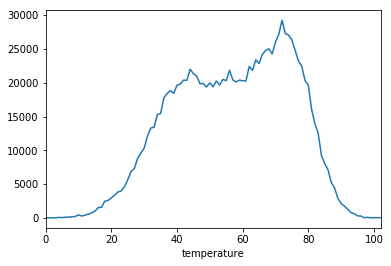

In [27]:
dfSeven.groupby('temperature').size().plot();

In [28]:
dfSeven['temperature'].min()

0.0

In [29]:
dfCrimesByTemp = dfSeven.groupby('temperature').size()
dfCrimesByTemp = pd.DataFrame(dfCrimesByTemp).reset_index()
dfCrimesByTemp.columns = ['Temperature', 'Count_crime']
dfCrimesByTemp.head()

,Temperature,Count_crime
0,0.0,4
1,1.0,3
2,2.0,23
3,3.0,12
4,4.0,86


In [30]:
dfTempNorm = dfSeven.groupby(['temperature','datetime_adj']).size()
dfTempNorm = pd.DataFrame(dfTempNorm).reset_index()
dfTempByHour = dfTempNorm.groupby('temperature').size()
dfTempByHour = pd.DataFrame(dfTempByHour).reset_index()
dfTempByHour.columns = ['Temperature', 'Count_hour']
dfTempByHour.head()

,Temperature,Count_hour
0,0.0,1
1,1.0,1
2,2.0,4
3,3.0,3
4,4.0,12


In [31]:
dfTempNormalized = pd.merge(dfTempByHour, dfCrimesByTemp, on='Temperature')

In [32]:
dfTempNormalized['avgCrimePerHour'] = dfTempNormalized.Count_crime / dfTempNormalized.Count_hour

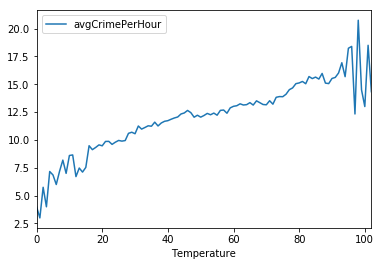

In [33]:
dfTempNormalized.plot('Temperature', 'avgCrimePerHour')

In [34]:
tempMod = smf.ols("avgCrimePerHour ~ Temperature", data=dfTempNormalized)
tempFit = tempMod.fit()
tempFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        avgCrimePerHour   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     630.0
Date:                Fri, 27 Apr 2018   Prob (F-statistic):           3.32e-45
Time:                        09:50:35   Log-Likelihood:                -164.10
No. Observations:                 103   AIC:                             332.2
Df Residuals:                     101   BIC:                             337.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       6.9062      0.235     29.367      0.000         6.440     7.373
Temperature     0.1000      0.004     25.099      0.000         0.092     0.108
==============================================================================
Omnibus:                       33.966   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.103
Skew:                          -1.177   Prob(JB):                     7.39e-20
Kurtosis:                       6.872   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

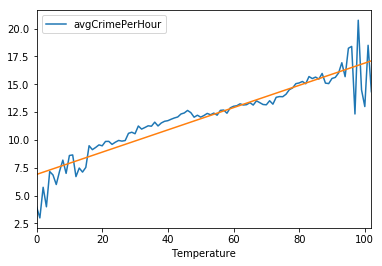

In [35]:
dfTempNormalized.plot('Temperature', 'avgCrimePerHour')
tempFitLine = tempFit.fittedvalues
pl.plot(tempFitLine);

# Turning the above work into a function

In [101]:
# Defining our function

def weatherCorrelation (dataframe, crime, weatherType, outliers=False, regression=True):
    
    """Does all of the above, but allows us to specify the specific crime type and weather type"""
    
    # Reducing dataframe based on selected crime type (listing no crime yields all results
    
    if crime == 'ALL CRIME':
        dataframe = dataframe
    else:
        dataframe = dataframe.loc[dataframe['OFNS_DESC'] == crime]
    
    # Removing weather outliers - first and last fifth
    
    if outliers == True:
        outCount = ((dataframe[weatherType].max() - dataframe[weatherType].min()) / 5)
        weatherMin = dataframe[weatherType].min() + outCount
        weatherMax = dataframe[weatherType].max() - outCount
        dataframe = dataframe[(dataframe[weatherType] >= weatherMin) & (dataframe[weatherType] <= weatherMax)]
    else:
        dataframe = dataframe
    
    # Reducing crime type by weather event
    
    dfCrimesByWeather = dataframe.groupby(weatherType).size()
    dfCrimesByWeather = pd.DataFrame(dfCrimesByWeather).reset_index()
    dfCrimesByWeather.columns = [weatherType, 'Count_crime']
    
    # Calculating number of hours of each weather pattern
    
    dfWeatherNorm = dataframe.groupby([weatherType,'datetime_adj']).size()
    dfWeatherNorm = pd.DataFrame(dfWeatherNorm).reset_index()
    dfWeatherByHour = dfWeatherNorm.groupby(weatherType).size()
    dfWeatherByHour = pd.DataFrame(dfWeatherByHour).reset_index()
    dfWeatherByHour.columns = [weatherType, 'Count_hour']

    # Getting average Crime per Hour
    
    dfWeatherNormalized = pd.merge(dfCrimesByWeather, dfWeatherByHour, on=weatherType)
    dfWeatherNormalized['CrimePerHour'] = dfWeatherNormalized.Count_crime / dfWeatherNormalized.Count_hour
    
    # Fit a linear/polynomial model 
    
    if weatherType == 'windBearing':
        weatherMod = smf.ols(formula = "CrimePerHour ~ windBearing + I(windBearing**2)", data=dfWeatherNormalized)
    else:
        weatherMod = smf.ols("CrimePerHour ~ " + weatherType, data=dfWeatherNormalized)

    weatherFit = weatherMod.fit()
    weatherFitLine = weatherFit.fittedvalues    
    
    if regression==True:

        # Regression summary 
        #x = weatherFit.summary()
        #print("\n\n" + crime + " Regression Results:\n\n\n", x)
        
        # R-squared, P-Value, and plot

        adjRSqu = weatherFit.rsquared
        pValue = weatherFit.pvalues[1]
        y = dfWeatherNormalized.plot(weatherType, 'CrimePerHour', title=crime, legend=False)
        z = pl.plot(weatherFitLine);
    
        # Print & Plot    
        
        print("\n" + crime + " Regression Results:\n\nR-Squared Value: ", adjRSqu, "\nP-Value: ", pValue)
        return y, z
       
    else:
        
        #Print & Plot without Regression
        
        y = dfWeatherNormalized.plot(weatherType, 'CrimePerHour', title=crime, legend=False)
        return y

# Using the function for different weather and crime types

## Temperature

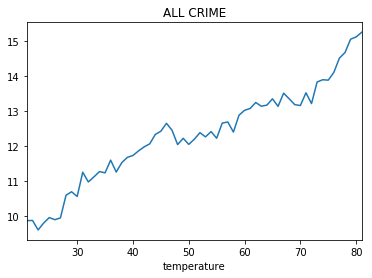

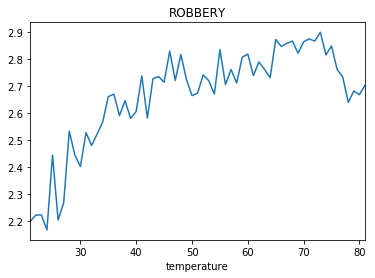

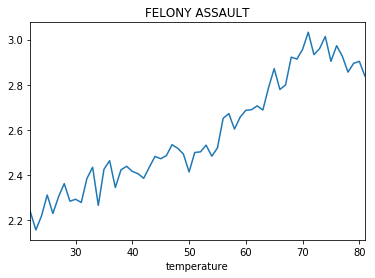

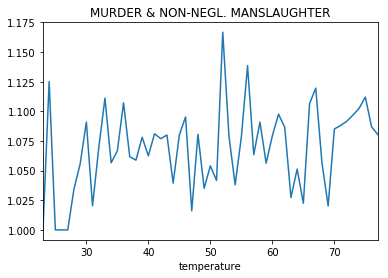

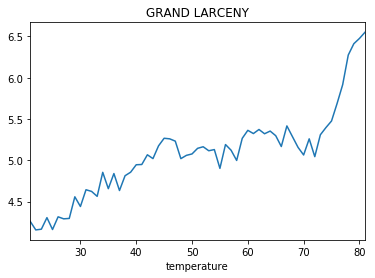

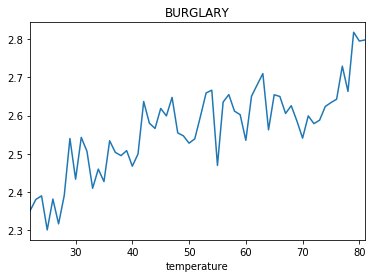

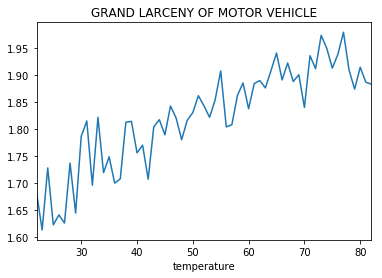

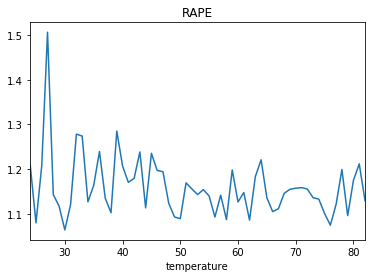

In [99]:
felonyTypes = ['ALL CRIME', 'ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'temperature', outliers=True, regression=False)

## Apparent Temperature


ALL CRIME Regression Results:

R-Squared Value:  0.892348540745 
P-Value:  1.58827337393e-38

ROBBERY Regression Results:

R-Squared Value:  0.593709446407 
P-Value:  1.0163086917e-16

FELONY ASSAULT Regression Results:

R-Squared Value:  0.883607729659 
P-Value:  3.10000086584e-37

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0297423966375 
P-Value:  0.14455903299

GRAND LARCENY Regression Results:

R-Squared Value:  0.726452035092 
P-Value:  2.24090718122e-23

BURGLARY Regression Results:

R-Squared Value:  0.537084069946 
P-Value:  2.39600535857e-14

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.688223679585 
P-Value:  6.37956392732e-21

RAPE Regression Results:

R-Squared Value:  0.0167882554235 
P-Value:  0.264614625497


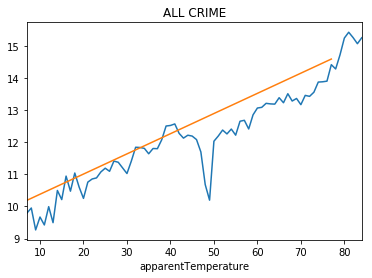

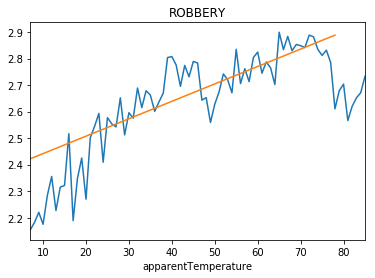

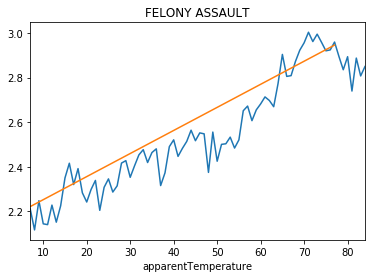

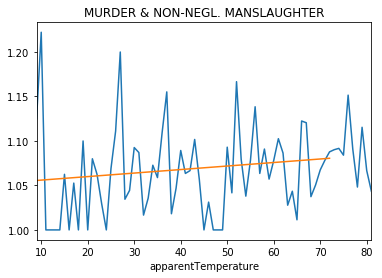

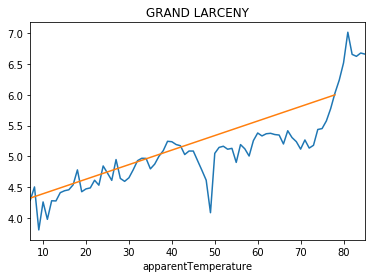

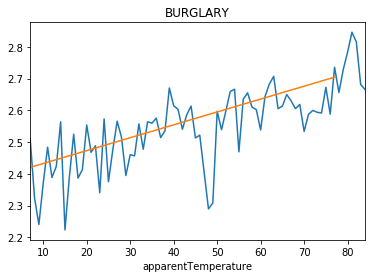

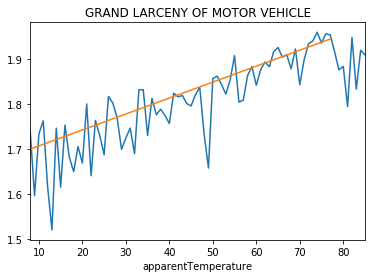

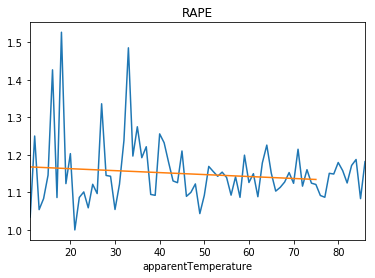

In [38]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'apparentTemperature', outliers=True)

## Dew Point


ALL CRIME Regression Results:

R-Squared Value:  0.915701107545 
P-Value:  9.27590032775e-32

ROBBERY Regression Results:

R-Squared Value:  0.623186102548 
P-Value:  1.80190802807e-13

FELONY ASSAULT Regression Results:

R-Squared Value:  0.880270853025 
P-Value:  1.74655903414e-27

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0138784521666 
P-Value:  0.391666015783

GRAND LARCENY Regression Results:

R-Squared Value:  0.755276313627 
P-Value:  9.2765843476e-19

BURGLARY Regression Results:

R-Squared Value:  0.648520052204 
P-Value:  4.28597045986e-14

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.671803235077 
P-Value:  3.63462636453e-15

RAPE Regression Results:

R-Squared Value:  0.00303223265968 
P-Value:  0.686884912304


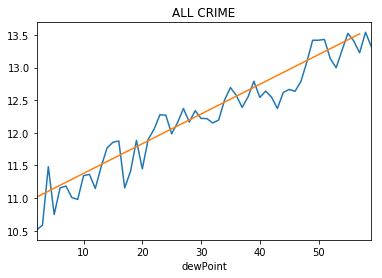

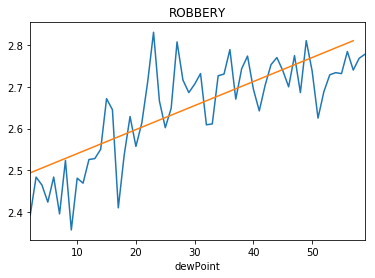

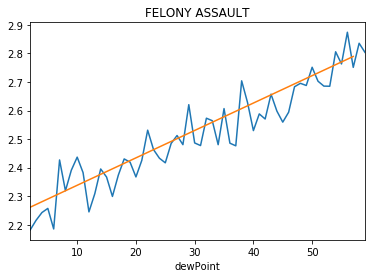

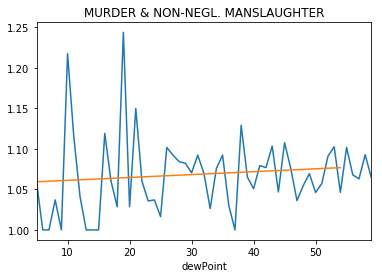

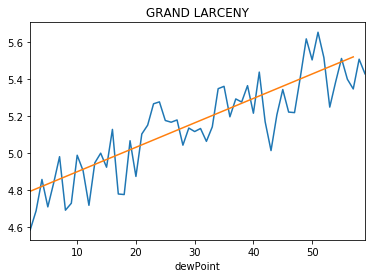

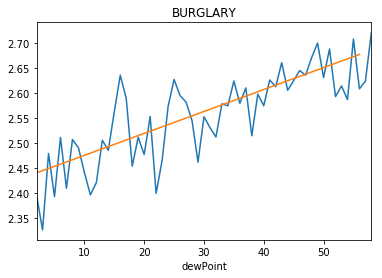

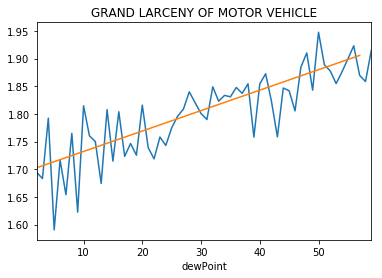

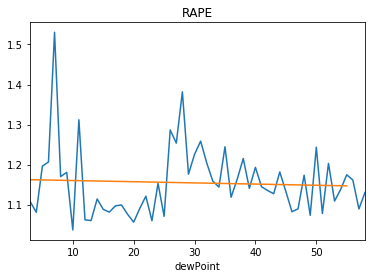

In [39]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'dewPoint', outliers=True)

## Visibility


ALL CRIME Regression Results:

R-Squared Value:  0.355562743005 
P-Value:  5.91647008774e-11

ROBBERY Regression Results:

R-Squared Value:  0.110273452082 
P-Value:  0.000737322116754

FELONY ASSAULT Regression Results:

R-Squared Value:  0.478240632833 
P-Value:  1.64748085537e-15

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.00772461046057 
P-Value:  0.389476127669

GRAND LARCENY Regression Results:

R-Squared Value:  0.251222864974 
P-Value:  1.08730654127e-07

BURGLARY Regression Results:

R-Squared Value:  5.55103397715e-06 
P-Value:  0.981439332275

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0619565051402 
P-Value:  0.0125161136942

RAPE Regression Results:

R-Squared Value:  0.03306638487 
P-Value:  0.0716440838703


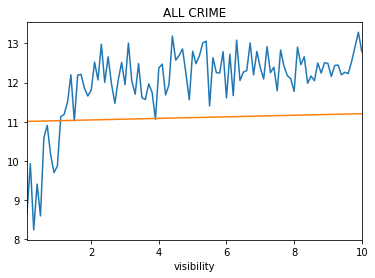

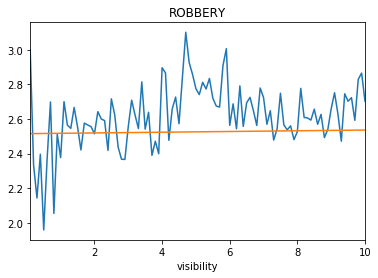

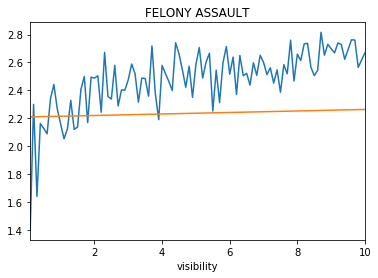

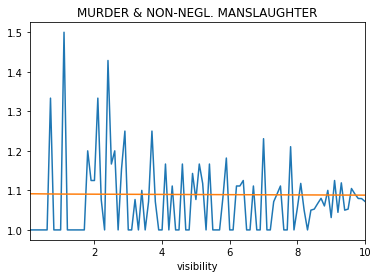

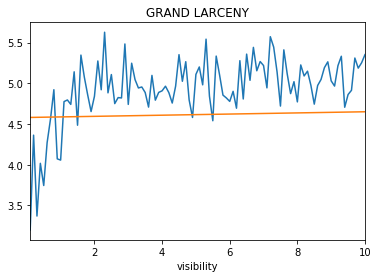

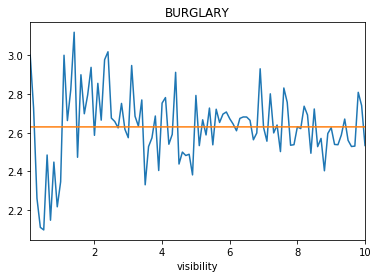

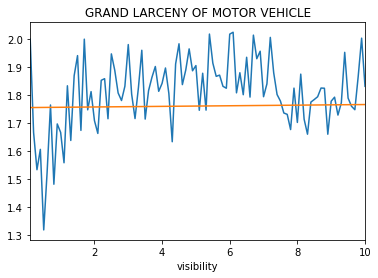

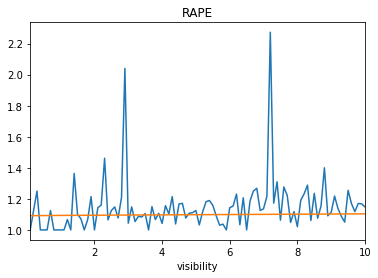

In [40]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'visibility')

## Wind Speed


ALL CRIME Regression Results:

R-Squared Value:  7.73215643091e-05 
P-Value:  0.95821351682

ROBBERY Regression Results:

R-Squared Value:  0.378107847523 
P-Value:  3.99631357262e-05

FELONY ASSAULT Regression Results:

R-Squared Value:  0.614983405167 
P-Value:  9.35807445978e-09

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.00996028028249 
P-Value:  0.586813659939

GRAND LARCENY Regression Results:

R-Squared Value:  0.151622843357 
P-Value:  0.0156750118382

BURGLARY Regression Results:

R-Squared Value:  0.504684135253 
P-Value:  5.84171742496e-07

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0187615641122 
P-Value:  0.412200700221

RAPE Regression Results:

R-Squared Value:  0.388631057556 
P-Value:  0.000138110122768


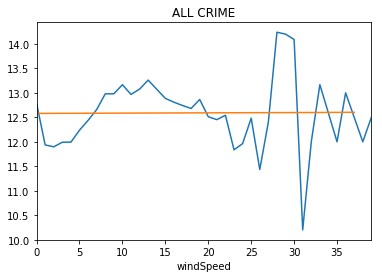

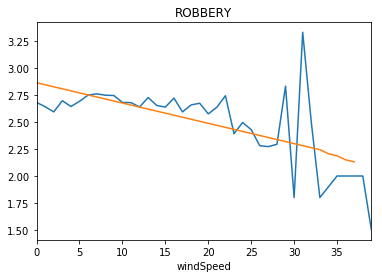

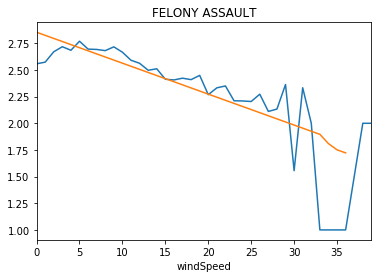

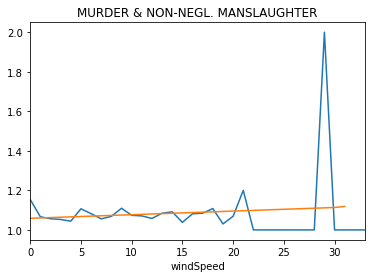

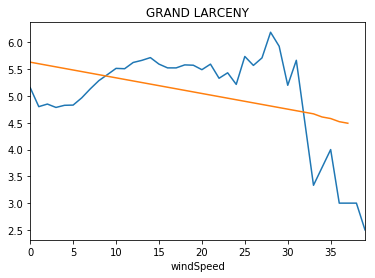

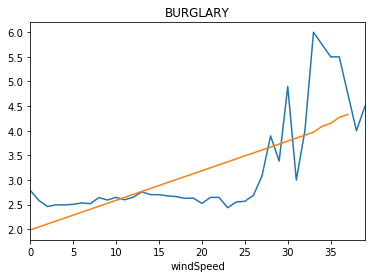

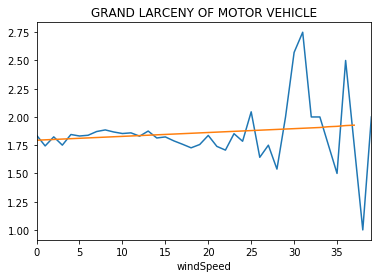

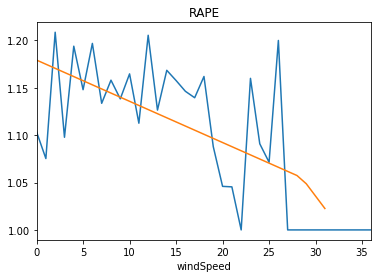

In [41]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'windSpeed')

## Pressure


ALL CRIME Regression Results:

R-Squared Value:  0.0503456958561 
P-Value:  0.0468163836125

ROBBERY Regression Results:

R-Squared Value:  0.15619689463 
P-Value:  0.000410354963644

FELONY ASSAULT Regression Results:

R-Squared Value:  0.190497969704 
P-Value:  8.09739449595e-05

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0401648508072 
P-Value:  0.142352938068

GRAND LARCENY Regression Results:

R-Squared Value:  0.0746752466309 
P-Value:  0.0154890268065

BURGLARY Regression Results:

R-Squared Value:  0.131666790098 
P-Value:  0.0010946937562

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0165272189892 
P-Value:  0.265161828319

RAPE Regression Results:

R-Squared Value:  0.00347822688162 
P-Value:  0.648873687662


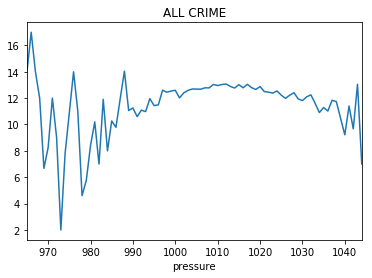

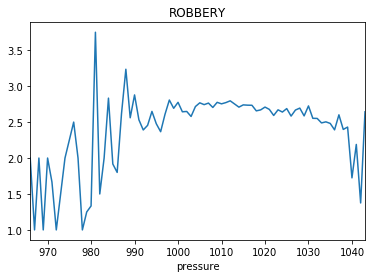

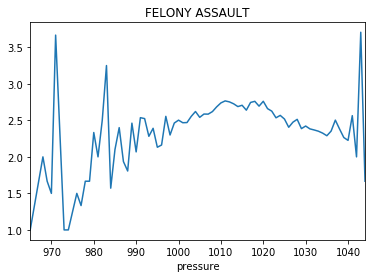

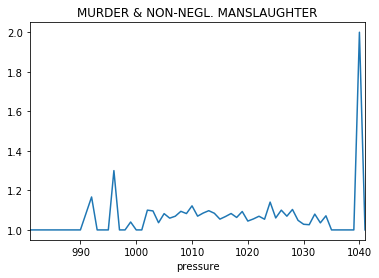

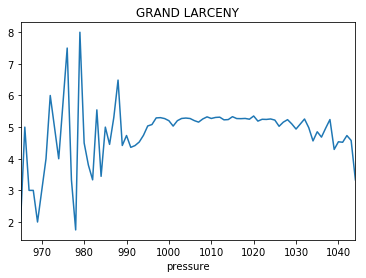

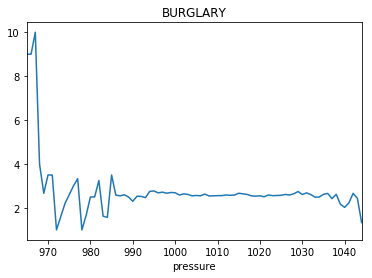

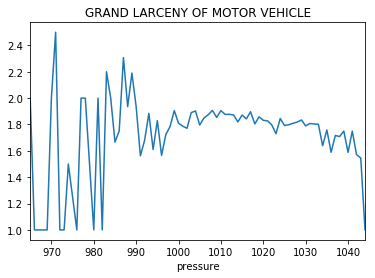

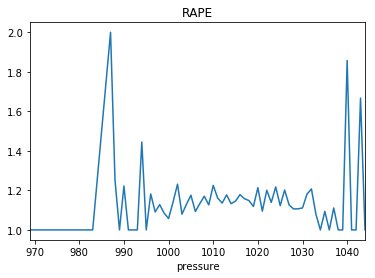

In [42]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'pressure')

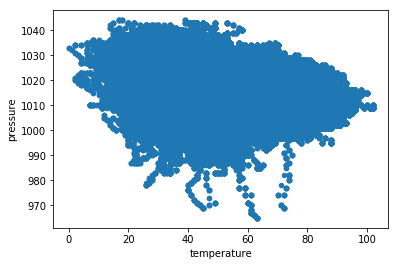

In [43]:
dfSeven.plot.scatter(x='temperature', y='pressure');

### A note on pressure: when the pressure is between 1000 and 1030 PSUs there appears to be some stationarity in the amount of crime that occurs. Outside of this range there appears to be little predictability. 

## Precipitation - Intensity


ALL CRIME Regression Results:

R-Squared Value:  0.0019710183255 
P-Value:  0.0720078808343

ROBBERY Regression Results:

R-Squared Value:  0.000858323269872 
P-Value:  0.249933822074

FELONY ASSAULT Regression Results:

R-Squared Value:  1.55638737775e-06 
P-Value:  0.961585322074

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.000116422227096 
P-Value:  0.849203477871

GRAND LARCENY Regression Results:

R-Squared Value:  0.00121639589992 
P-Value:  0.163326023405

BURGLARY Regression Results:

R-Squared Value:  0.000171380864872 
P-Value:  0.606430230485

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.00753918807129 
P-Value:  0.00126404251627

RAPE Regression Results:

R-Squared Value:  0.000115296265446 
P-Value:  0.789431856569


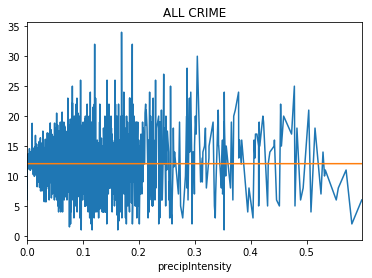

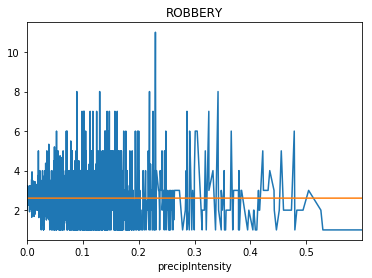

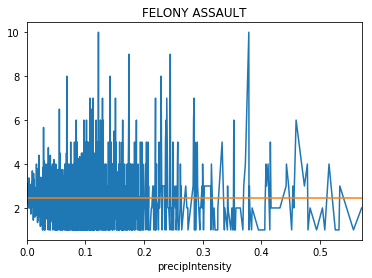

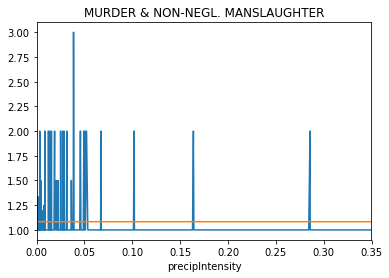

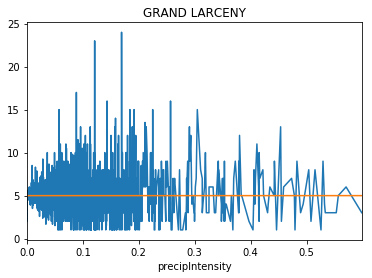

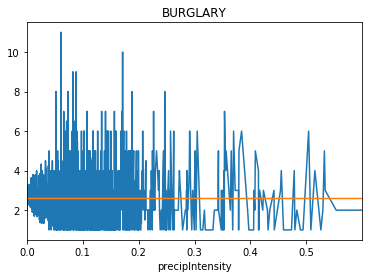

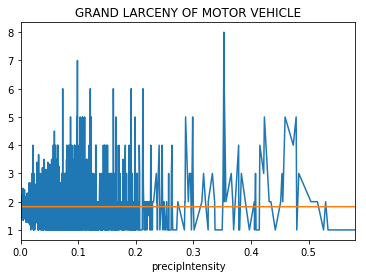

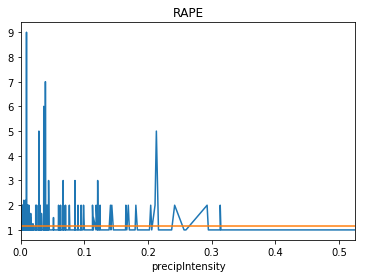

In [44]:
dfPrecipIntens = dfSeven.loc[dfSeven['precipIntensity'] <= 0.6]

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfPrecipIntens, i, 'precipIntensity')

## Precipitation - Accumulation
#### For precipitation accumulation, we rarely see amounts higher than ~3 inches.. let's run this function again with a dataframe that cuts off precipitation amounts higher than 3


ALL CRIME Regression Results:

R-Squared Value:  0.0249277896085 
P-Value:  0.422314405088

ROBBERY Regression Results:

R-Squared Value:  0.00218818927574 
P-Value:  0.824284850285

FELONY ASSAULT Regression Results:

R-Squared Value:  0.00125608642014 
P-Value:  0.872454279771

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0350595803246 
P-Value:  0.657040657733

GRAND LARCENY Regression Results:

R-Squared Value:  0.00773594903823 
P-Value:  0.662658939329

BURGLARY Regression Results:

R-Squared Value:  0.00438391485238 
P-Value:  0.758547676926

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0155985081303 
P-Value:  0.56092066843

RAPE Regression Results:

R-Squared Value:  0.234699036766 
P-Value:  0.0487535543929


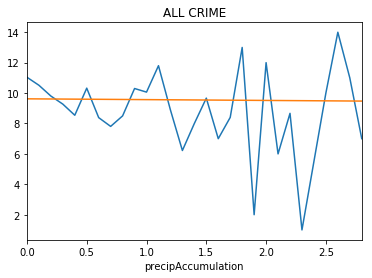

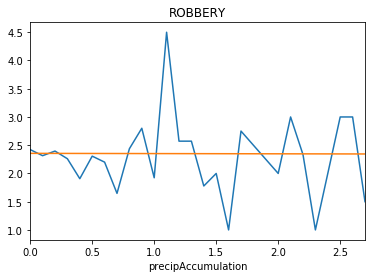

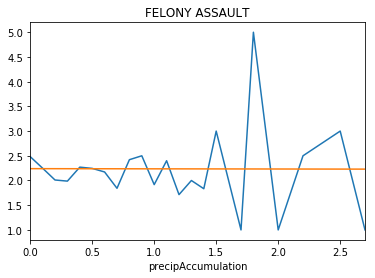

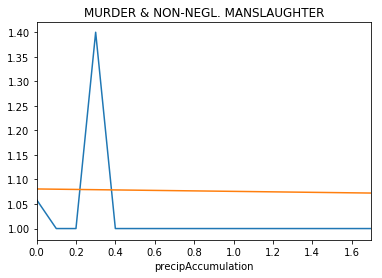

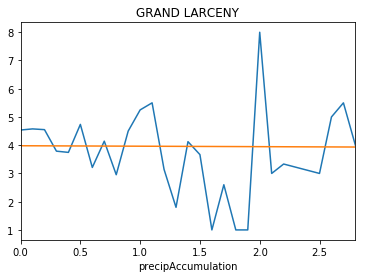

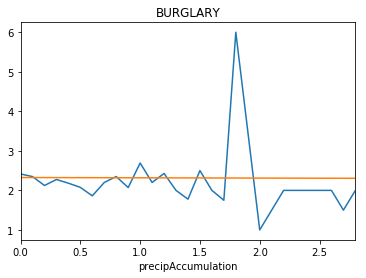

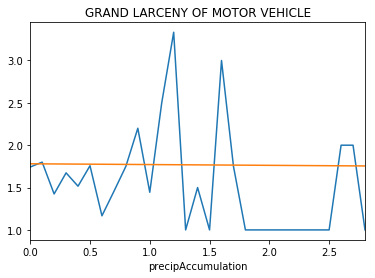

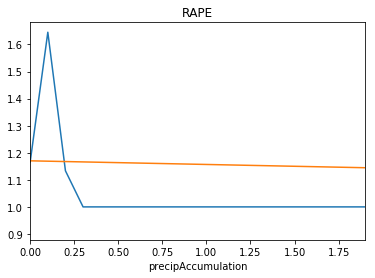

In [45]:
dfPrecipAccum = dfSeven.loc[dfSeven['precipAccumulation'] <= 3]

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfPrecipAccum, i, 'precipAccumulation')

## Cloud Cover


ALL CRIME Regression Results:

R-Squared Value:  0.0239603272695 
P-Value:  0.142907905556

ROBBERY Regression Results:

R-Squared Value:  0.168776417643 
P-Value:  5.23381258424e-05

FELONY ASSAULT Regression Results:

R-Squared Value:  0.290664315375 
P-Value:  3.5177657026e-08

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0244378851729 
P-Value:  0.138938320202

GRAND LARCENY Regression Results:

R-Squared Value:  0.135286771381 
P-Value:  0.000334747105611

BURGLARY Regression Results:

R-Squared Value:  0.151144820453 
P-Value:  0.000139895553637

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0469854060539 
P-Value:  0.0390375566986

RAPE Regression Results:

R-Squared Value:  0.0124544599705 
P-Value:  0.292263475613


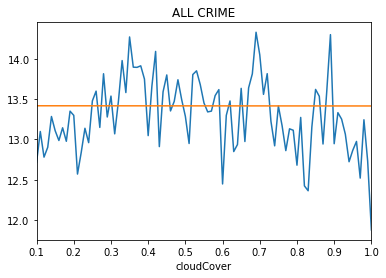

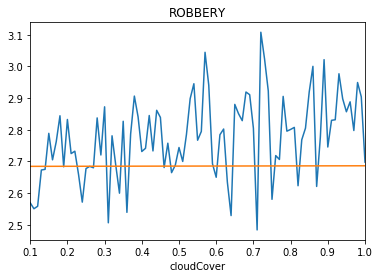

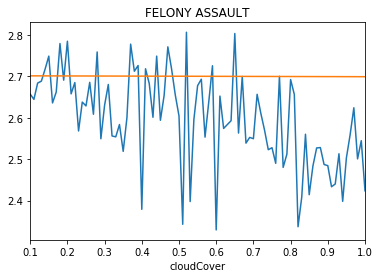

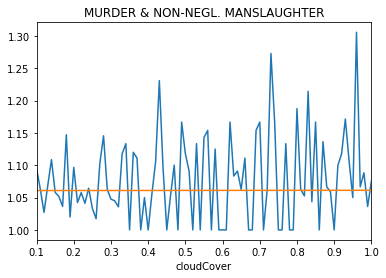

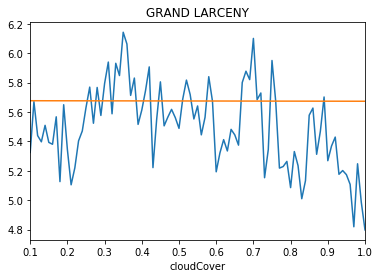

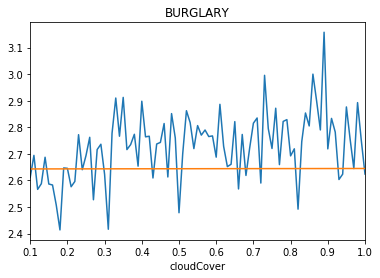

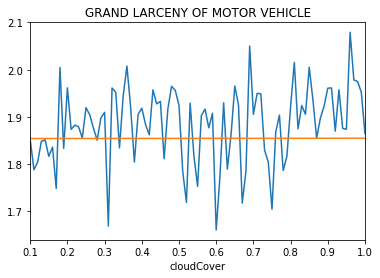

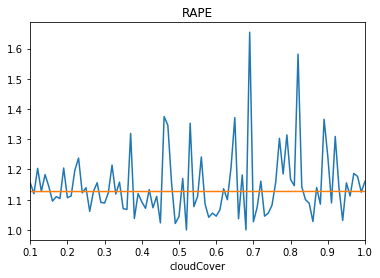

In [46]:
dfCloud = dfSeven.loc[dfSeven['cloudCover'] >= 0.1]

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfCloud, i, 'cloudCover')

## Wind Bearing


ALL CRIME Regression Results:

R-Squared Value:  0.617267270491 
P-Value:  5.43136526658e-74

ROBBERY Regression Results:

R-Squared Value:  0.296272083089 
P-Value:  6.65790492674e-29

FELONY ASSAULT Regression Results:

R-Squared Value:  0.336181064325 
P-Value:  1.42162431295e-33

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.00435895665365 
P-Value:  0.601951754863

GRAND LARCENY Regression Results:

R-Squared Value:  0.425955706184 
P-Value:  2.36943190571e-41

BURGLARY Regression Results:

R-Squared Value:  0.0728859838451 
P-Value:  0.470663226717

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.186587536065 
P-Value:  1.46128226615e-17

RAPE Regression Results:

R-Squared Value:  0.0158158072828 
P-Value:  0.236252944798


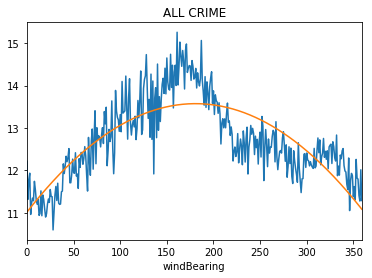

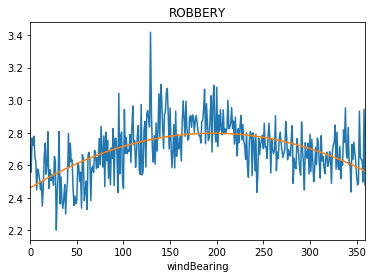

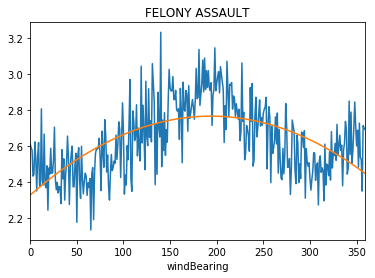

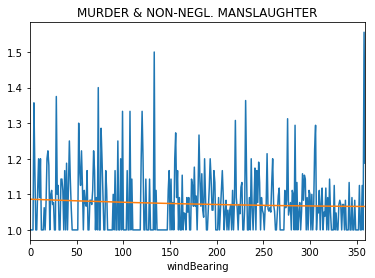

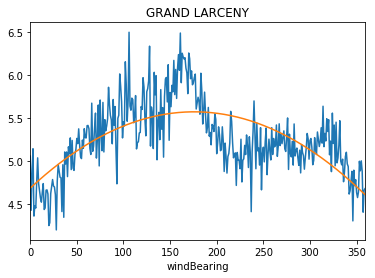

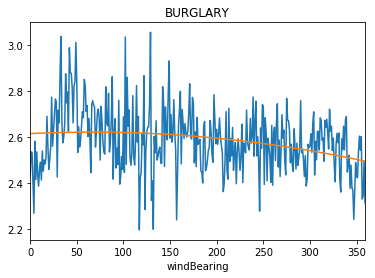

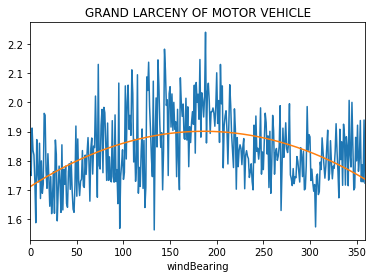

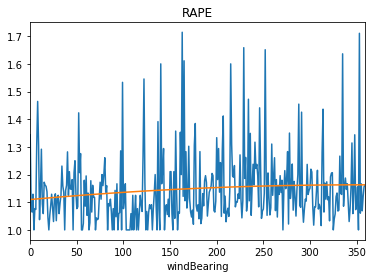

In [103]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'windBearing', regression=True)

# Examining Wind Bearing Further

## Reducing to outdoor crimes only

In [93]:
maybeOutdoor = ['STREET', 'PARK/PLAYGROUND', 'PARKING LOT/GARAGE (PUBLIC)', 'GAS STATION', 'TUNNEL',
       'TRANSIT - NYC SUBWAY', 'BUS (NYC TRANSIT)', 'PARKING LOT/GARAGE (PRIVATE)',
       'FERRY/FERRY TERMINAL', 'CONSTRUCTION SITE', 'BUS STOP', 'BRIDGE', 'OPEN AREAS (OPEN LOTS)', 'MARINA/PIER',
       'HIGHWAY/PARKWAY', 'BUS TERMINAL', 'CEMETERY', 'TRAMWAY']

outdoor = ['STREET', 'PARK/PLAYGROUND', 'TUNNEL', 'CONSTRUCTION SITE', 'BUS STOP', 'BRIDGE', 'OPEN AREAS (OPEN LOTS)',
           'MARINA/PIER', 'HIGHWAY/PARKWAY', 'BUS TERMINAL', 'CEMETERY']

dfSevenMaybeOutdoor = dfSeven.loc[dfSeven['PREM_TYP_DESC'].isin(maybeOutdoor)]
dfSevenOutdoor = dfSeven.loc[dfSeven['PREM_TYP_DESC'].isin(outdoor)]
dfSevenIndoor = dfSeven.loc[~dfSeven['PREM_TYP_DESC'].isin(maybeOutdoor)]

In [50]:
# DONT RUN AGAIN
#dfSevenMaybeOutdoor = dfSevenMaybeOutdoor.drop(['level_0', 'index'], axis=1)
dfSevenMaybeOutdoor  = pd.DataFrame(dfSevenMaybeOutdoor).reset_index()

In [51]:
# DONT RUN AGAIN
#dfSevenOutdoor = dfSevenOutdoor.drop(['level_0', 'index'], axis=1)
dfSevenOutdoor  = pd.DataFrame(dfSevenOutdoor).reset_index()

#### Also considering indoor crimes only

In [94]:
# DONT RUN AGAIN
#dfSevenIndoor = dfSevenIndoor.drop(['level_0', 'index'], axis=1)
dfSevenIndoor  = pd.DataFrame(dfSevenIndoor).reset_index()

In [52]:
dfSevenOutdoor.head()

,index,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed,datetime_y,datetime_adj
0,2,898496564,12/31/2015,23:00:00,NaN,NaN,12/31/2015,109,GRAND LARCENY,406.0,...,NaN,1019.0,Clear,43.0,1.451621e+09,10.0,308.0,10.0,2016-01-01 04:00:00,2015-12-31 23:00:00
1,3,566081066,12/31/2015,23:00:00,NaN,NaN,12/31/2015,109,GRAND LARCENY,415.0,...,NaN,1019.0,Clear,43.0,1.451621e+09,10.0,308.0,10.0,2016-01-01 04:00:00,2015-12-31 23:00:00
2,9,590638275,12/31/2015,22:30:00,NaN,NaN,12/31/2015,106,FELONY ASSAULT,109.0,...,NaN,1019.0,Clear,43.0,1.451621e+09,10.0,308.0,10.0,2016-01-01 04:00:00,2015-12-31 23:00:00
3,16,229815464,12/31/2015,22:00:00,12/31/2015,22:15:00,12/31/2015,106,FELONY ASSAULT,105.0,...,NaN,1019.0,Mostly Cloudy,44.0,1.451617e+09,10.0,313.0,13.0,2016-01-01 03:00:00,2015-12-31 22:00:00
4,21,788055451,12/31/2015,20:38:00,12/31/2015,20:38:00,12/31/2015,106,FELONY ASSAULT,109.0,...,NaN,1019.0,Partly Cloudy,44.0,1.451614e+09,10.0,300.0,11.0,2016-01-01 02:00:00,2015-12-31 21:00:00


### There's an issue here where we cannot reset the index of the new dataframe... this is impacting the ability to run through the function we created, which requires the index to reset... for some reason, it DOES still work for certain types of crime (all, robbery, and felony assault)


ALL CRIME Regression Results:

R-Squared Value:  0.570100597922 
P-Value:  2.09127702223e-66

ROBBERY Regression Results:

R-Squared Value:  0.148319908937 
P-Value:  4.89760453931e-14

FELONY ASSAULT Regression Results:

R-Squared Value:  0.112766386524 
P-Value:  6.591082083e-11


ValueError: zero-size array to reduction operation maximum which has no identity

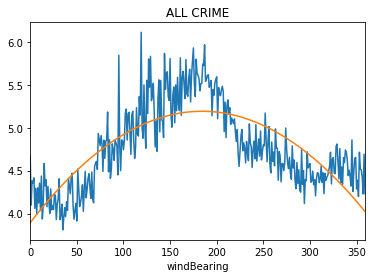

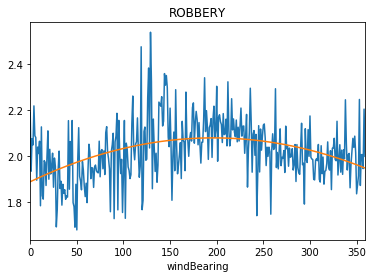

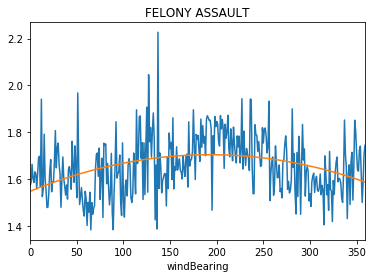

In [104]:
for i in felonyTypes:
    weatherCorrelation(dfSevenOutdoor, i, 'windBearing')


ALL CRIME Regression Results:

R-Squared Value:  0.570100597922 
P-Value:  2.09127702223e-66


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5458eabeb8>,
 [<matplotlib.lines.Line2D at 0x7f5458eab400>])

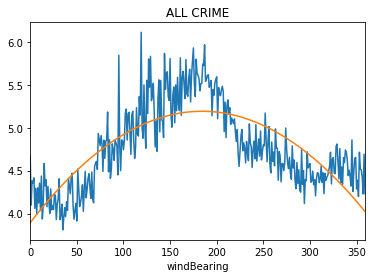

In [105]:
weatherCorrelation(dfSevenOutdoor, 'ALL CRIME', 'windBearing')

#### The above plot shows that, when we filter for crimes that we believe to have taken place outdoors, we still see the same distribution. 


ALL CRIME Regression Results:

R-Squared Value:  0.414919767943 
P-Value:  1.50280323581e-40


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5458f11320>,
 [<matplotlib.lines.Line2D at 0x7f5458f0b390>])

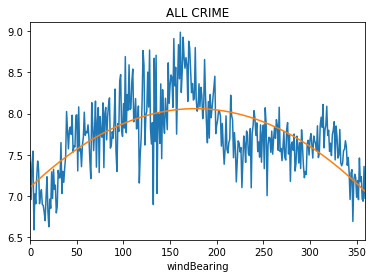

In [106]:
weatherCorrelation(dfSevenIndoor, 'ALL CRIME', 'windBearing')

### The above figure shows the distribution if we exclude outdoor crimes and only look at those taking place indoors. We see that the distribution holds

### Examining temperature and wind bearing for correlation

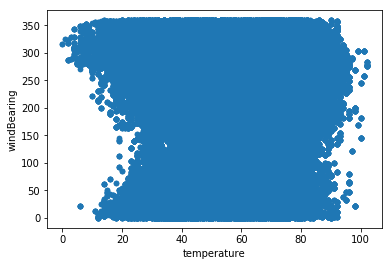

In [55]:
dfSeven.plot.scatter(x='temperature', y='windBearing');

#### This is kind of messy...let's take a random sampling of every 3000th row

In [56]:
dfSample = dfSeven.iloc[::3000, :]

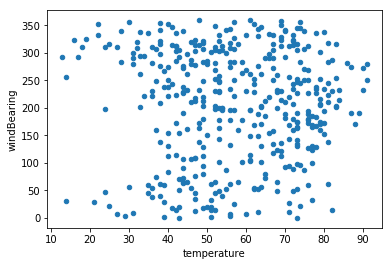

In [57]:
dfSample.plot.scatter(x='temperature', y='windBearing');

#### This shows us with a little more definition that southern winds are less likely to occur at lower temperatures. What would happen if we plot crimes that happen at 20 degrees (or higher), eliminating this hole?

In [58]:
dvSevenHigherTemps = dfSeven[(dfSeven['temperature'] >= 40)]

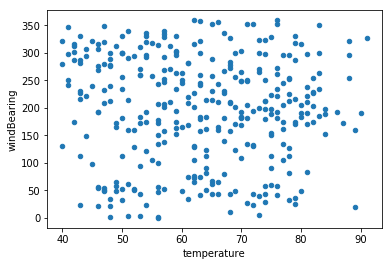

In [59]:
dfSevenHigherTempsSample = dvSevenHigherTemps.iloc[::3000, :]
dfSevenHigherTempsSample.plot.scatter(x='temperature', y='windBearing');

#### The above plot reveals the general randomness of wind bearing against temperature, once we set the lower limit to 40 degrees. Let's take a look at the correlation again using the new dataframe, so as to remove any low-temperature extremes.


ALL CRIME Regression Results:

R-Squared Value:  0.487708432664 
P-Value:  1.20896095652e-53


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5458e185f8>,
 [<matplotlib.lines.Line2D at 0x7f5458f59278>])

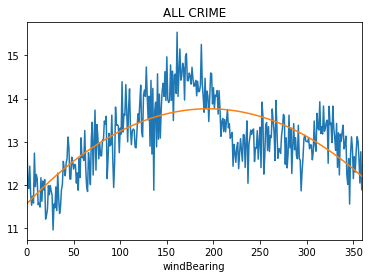

In [107]:
weatherCorrelation(dvSevenHigherTemps, 'ALL CRIME', 'windBearing')

#### Limiting our data to higher temperatures (no lower than 40 degrees) still leaves us with a visible correlation... what else could account for this? Maybe it's a temporal correlation, with southern winds occuring more frequently in the summer.

#### Before we get into that though, let's look at 10 degree increments to see if the pattern will exist on a smaller scale..

In [61]:
dfSevenTenTemps = dfSeven[(dfSeven['temperature'] >= 60) & (dfSeven['temperature'] <= 70)]


ALL CRIME Regression Results:

R-Squared Value:  0.226824471771 
P-Value:  3.37670393259e-19


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5458f644e0>,
 [<matplotlib.lines.Line2D at 0x7f5458e22d68>])

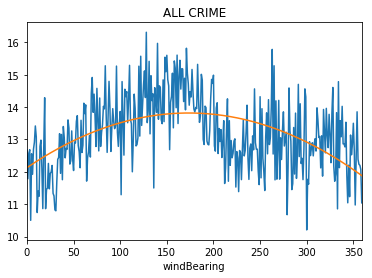

In [108]:
weatherCorrelation(dfSevenTenTemps, 'ALL CRIME', 'windBearing')

#### You don't get much from this... I tested this method for all intervals of 10 between 20 and 100 degrees, and at no point do you see a clear pattern. It's only when you expand the spread that the pattern reveals itself

## Time Series Analysis of wind bearing

In [63]:
weather.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed,datetime,datetime_adj
0,26.80,0.82,28.43,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1009.73,Mostly Cloudy,32.48,1136091600,8.84,335.0,6.00,2006-01-01 05:00:00,2006-01-01 00:00:00
1,27.04,0.77,28.32,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1010.35,Mostly Cloudy,32.33,1136095200,7.67,345.0,5.49,2006-01-01 06:00:00,2006-01-01 01:00:00
2,27.21,0.78,28.34,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1011.40,Mostly Cloudy,32.29,1136098800,8.69,344.0,5.23,2006-01-01 07:00:00,2006-01-01 02:00:00
3,27.01,0.34,27.97,0.84,partly-cloudy-night,NaN,0.0,0.0,NaN,1012.17,Partly Cloudy,32.19,1136102400,8.79,345.0,5.32,2006-01-01 08:00:00,2006-01-01 03:00:00
4,26.65,0.95,28.10,0.85,cloudy,NaN,0.0,0.0,NaN,1012.67,Overcast,32.00,1136106000,8.41,339.0,5.49,2006-01-01 09:00:00,2006-01-01 04:00:00


In [64]:
weather['month'] = weather['datetime_adj'].dt.month

In [120]:
# 4 continuous days
n = 8
fourDays = weather.iloc[0:(24*n)]

# midnight
dailyWeatherMidnight = weather.iloc[::24, :] #midnight
dailyWeatherOneYear = dailyWeatherMidnight.iloc[0:365]
dailyWeatherTwoYears = dailyWeatherMidnight.iloc[0:730]
weeklyWeatherMidnight = dailyWeatherMidnight.iloc[::7, :]
weeklyWeatherOneYear = weeklyWeatherMidnight.iloc[0:52]

# noon
dailyWeatherNoon = weather.iloc[12::24, :] 
dailyWeatherNoonOneYear = dailyWeatherNoon.iloc[0:365]
dailyWeatherNoonTwoYears = dailyWeatherNoon.iloc[0:730]
weeklyWeatherNoon = dailyWeatherNoon.iloc[::7, :]
weeklyWeatherNoonOneYear = weeklyWeatherNoon.iloc[0:52]

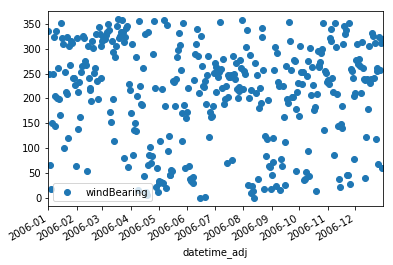

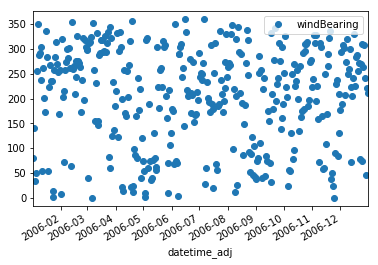

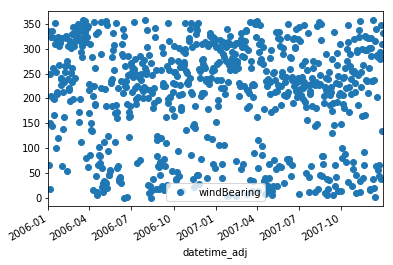

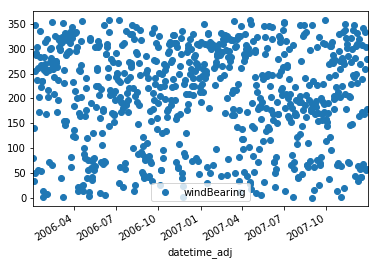

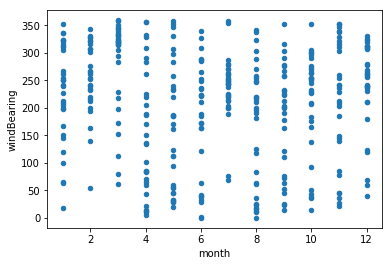

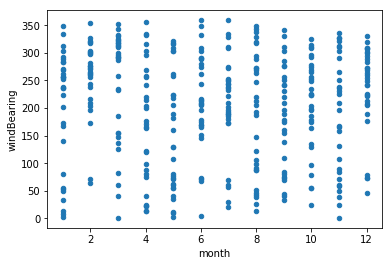

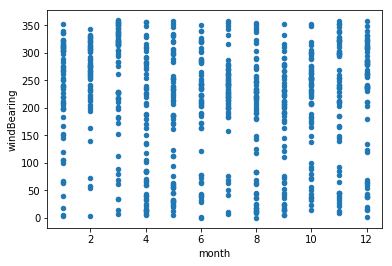

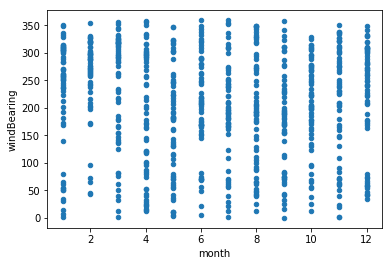

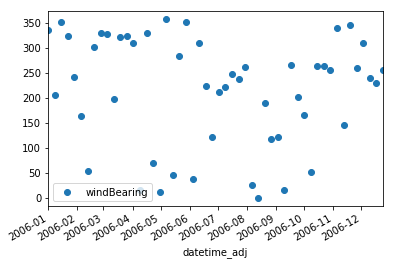

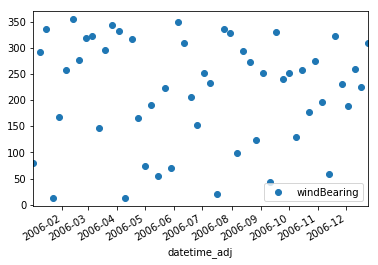

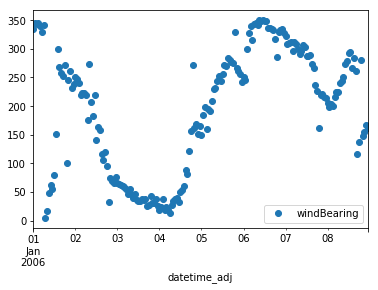

In [121]:
#print("Daily windbearing at midnight for one year:\n")
dailyWeatherOneYear.plot(x='datetime_adj', y='windBearing', style='o')
dailyWeatherNoonOneYear.plot(x='datetime_adj', y='windBearing', style='o')

#print("Daily windbearing at midnight for two years:\n")
dailyWeatherTwoYears.plot(x='datetime_adj', y='windBearing', style='o')
dailyWeatherNoonTwoYears.plot(x='datetime_adj', y='windBearing', style='o')

#print("Daily windbearing at midnight for one year:\n")
dailyWeatherOneYear.plot.scatter(x='month', y='windBearing', style='o')
dailyWeatherNoonOneYear.plot.scatter(x='month', y='windBearing', style='o')

#print("Daily windbearing at midnight for one year:\n")
dailyWeatherTwoYears.plot.scatter(x='month', y='windBearing', style='o')
dailyWeatherNoonTwoYears.plot.scatter(x='month', y='windBearing', style='o')

#print("Daily windbearing at midnight for one year:\n")
weeklyWeatherOneYear.plot(x='datetime_adj', y='windBearing', style='o')
weeklyWeatherNoonOneYear.plot(x='datetime_adj', y='windBearing', style='o')

#print("Daily windbearing at midnight for one year:\n")
fourDays.plot(x='datetime_adj', y='windBearing', style='o');

#### Looking at data for 365 continuous days, 730 continuous days, and 52 continuous weeks, there isn't a discernable temporal distribution of wind bearing. There are small holes here and there, but those do not appear to be based on any discernable pattern. 

# Mapping Weather & Crime

In [67]:
import choroplethNYC as cp
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame


## Southerly Winds

In [68]:
# Filter out crimes that occur when wind is not coming from the south
dfSouth = dfSeven.loc[(dfSeven['windBearing'] >= 160) & (dfSeven['windBearing'] <= 200)]

In [69]:
#dfSouth.columns

In [70]:
geometry = [Point(xy) for xy in zip(dfSouth.Longitude, dfSouth.Latitude)]
# dfSouth = dfSouth.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdfSouth = GeoDataFrame(dfSouth, crs=crs, geometry=geometry)

In [71]:
gdfSouth.head()

,level_0,index,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,pressure,summary,temperature,time,visibility,windBearing,windSpeed,datetime_y,datetime_adj,geometry
248,986,986,315719041,12/22/2015,08:00:00,12/28/2015,13:00:00,12/31/2015,109,GRAND LARCENY,...,1017.0,Clear,54.0,1.450789e+09,9.8,176.0,6.0,2015-12-22 13:00:00,2015-12-22 08:00:00,POINT (-73.98847201699999 40.739402283)
269,1080,1080,784751273,07/17/2015,00:01:00,07/24/2015,23:59:00,12/31/2015,109,GRAND LARCENY,...,1018.0,Clear,69.0,1.437106e+09,10.0,199.0,6.0,2015-07-17 04:00:00,2015-07-17 00:00:00,POINT (-73.98356551100001 40.77855547)
273,1089,1089,304095347,09/27/2014,20:51:00,NaN,NaN,12/31/2015,109,GRAND LARCENY,...,1021.0,Clear,73.0,1.411866e+09,10.0,187.0,4.0,2014-09-28 01:00:00,2014-09-27 21:00:00,POINT (-73.99045573399999 40.77162029300001)
274,1092,1092,840272043,08/19/2011,12:00:00,12/31/2015,11:00:00,12/31/2015,107,BURGLARY,...,1014.0,Partly Cloudy,78.0,1.313770e+09,9.4,195.0,5.0,2011-08-19 16:00:00,2011-08-19 12:00:00,POINT (-73.785240235 40.701226017)
522,2173,2174,582920285,12/24/2015,00:01:00,NaN,NaN,12/30/2015,109,GRAND LARCENY,...,1010.0,Clear,62.0,1.450933e+09,4.2,187.0,10.0,2015-12-24 05:00:00,2015-12-24 00:00:00,POINT (-73.97490979 40.732908785)


In [72]:
gdfS100 = gdfSouth.iloc[::100, :]
gdfS1000 = gdfSouth.iloc[::1000, :]
len(gdfS1000)

188

#### Importing Precincts Shapefile

In [73]:
#!wget "https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile"

In [74]:
#!unzip "78dh-3ptz?method=export&format=Shapefile"

In [75]:
filename = "geo_export_4c46ef28-7ec4-4d8d-b918-d3ce68c2fa56.shp"
precincts = gpd.GeoDataFrame.from_file(filename)

In [76]:
precincts.head()

,shape_area,shape_leng,precinct,geometry
0,4.730176e+07,80586.154615,1.0,(POLYGON ((-74.0438776157395 40.69018767637665...
1,1.808880e+07,18676.124259,5.0,POLYGON ((-73.98863862848766 40.72293372026369...
2,2.213193e+07,27182.610113,6.0,POLYGON ((-73.99968392160721 40.73855224865976...
3,1.836402e+07,17301.308682,7.0,"POLYGON ((-73.97345389423181 40.718962954076, ..."
4,2.139423e+07,19773.233410,9.0,POLYGON ((-73.97160900246391 40.72672340116989...


### Plotting Southerly Crimes

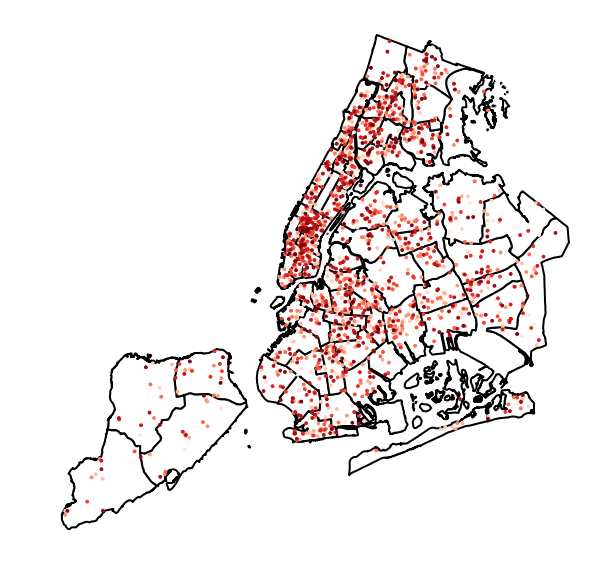

In [77]:
fig, ax = cp.choroplethNYC(precincts, color="white", edgecolor="black", lw=2)
gdfS100.plot(ax=ax, cmap='Reds', markersize=8)

#### Map of specific crime locations when wind bearing is southerly

### Northerly Winds

In [78]:
dfNorth = dfSeven.loc[(dfSeven['windBearing'] <= 22.5) | (dfSeven['windBearing'] >= 337.5)]

geometry = [Point(xy) for xy in zip(dfNorth.Longitude, dfNorth.Latitude)]
# dfSouth = dfSouth.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdfNorth = GeoDataFrame(dfNorth, crs=crs, geometry=geometry)

In [79]:
gdfN100 = gdfNorth.iloc[::100, :]
gdfN1000 = gdfNorth.iloc[::1000, :]

#### Plotting Northerly Crimes

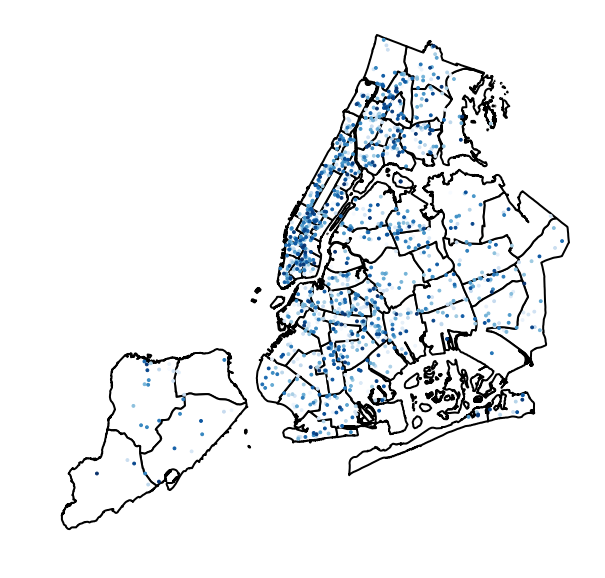

In [80]:
fig, ax = cp.choroplethNYC(precincts, color="white", edgecolor="black", lw=2)
gdfN100.plot(ax=ax, cmap='Blues', markersize=8);

### Looking at both maps, you can eyeball that there are fewer crimes when the winds are northerly, but there doesn't appear to be much of a different in the spacial distribution of crime. Let's take a look at choropleths to see if they offer a bit more insight

## Southerly Wind Choropleth

In [81]:
dfSouthPrecinct = dfSouth.groupby('ADDR_PCT_CD').size()
dfSouthPrecinct = pd.DataFrame(dfSouthPrecinct).reset_index()
dfSouthPrecinct.columns = ['precinct', 'Count_crime']

In [82]:
gdfSouthPrecinct = precincts.merge(dfSouthPrecinct, on='precinct')

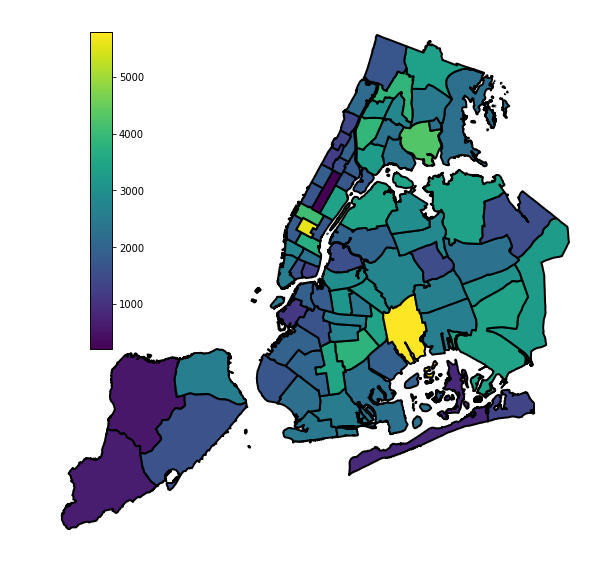

In [83]:
cp.choroplethNYC(gdfSouthPrecinct, column='Count_crime', color="white", edgecolor="black", lw=2);

## Northerly Wind Choropleth

In [84]:
dfNorthPrecinct = dfNorth.groupby('ADDR_PCT_CD').size()
dfNorthPrecinct = pd.DataFrame(dfNorthPrecinct).reset_index()
dfNorthPrecinct.columns = ['precinct', 'Count_crime']

In [85]:
gdfNorthPrecinct = precincts.merge(dfNorthPrecinct, on='precinct')

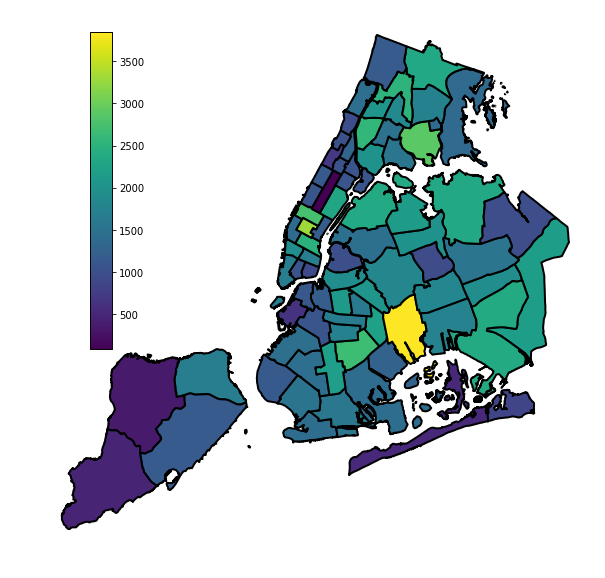

In [86]:
cp.choroplethNYC(gdfNorthPrecinct, column='Count_crime', color="white", edgecolor="black", lw=2);

### Comparing both choropleths, we see that there isn't a locative distinction of crime levels when it comes to wind bearing. However, the upper limit of crime in the southerly choropleth (~5500) is much higher than in the northerly (~3700). 

# Considering Predictive Power at Precinct Level

In [87]:
# Defining our new function

def precinctCorrelation (dataframe, crime, weatherType, precinct, outliers=False):
    
    """Does all of the above, but allows us to specify the specific crime type and weather type"""
    
    # Reducing dataframe based on precinct
    
    dataframe = dataframe.loc[dataframe['ADDR_PCT_CD'] == precinct]
    
    # Reducing dataframe based on selected crime type (listing no crime yields all results
    if crime == 'ALL CRIME':
        dataframe = dataframe
    else:
        dataframe = dataframe.loc[dataframe['OFNS_DESC'] == crime]
    
  # Removing weather outliers - first and last fifth
    
    if outliers == True:
        outCount = ((dataframe[weatherType].max() - dataframe[weatherType].min()) / 5)
        weatherMin = dataframe[weatherType].min() + outCount
        weatherMax = dataframe[weatherType].max() - outCount
        dataframe = dataframe[(dataframe[weatherType] >= weatherMin) & (dataframe[weatherType] <= weatherMax)]
    else:
        dataframe = dataframe
        
    # Reducing crime type by weather event
    
    dfCrimesByWeather = dataframe.groupby(weatherType).size()
    dfCrimesByWeather = pd.DataFrame(dfCrimesByWeather).reset_index()
    dfCrimesByWeather.columns = [weatherType, 'Count_crime']
    
    # Calculating number of hours of each weather pattern
    
    dfWeatherNorm = dataframe.groupby([weatherType,'datetime_adj']).size()
    dfWeatherNorm = pd.DataFrame(dfWeatherNorm).reset_index()
    dfWeatherByHour = dfWeatherNorm.groupby(weatherType).size()
    dfWeatherByHour = pd.DataFrame(dfWeatherByHour).reset_index()
    dfWeatherByHour.columns = [weatherType, 'Count_hour']

    # Getting average Crime per Hour
    
    dfWeatherNormalized = pd.merge(dfCrimesByWeather, dfWeatherByHour, on=weatherType)
    dfWeatherNormalized['CrimePerHour'] = dfWeatherNormalized.Count_crime / dfWeatherNormalized.Count_hour
    
    # Fit a regression model
    
    
#     if weatherType == 'windBearing':
#        weatherMod = smf.ols("CrimePerHour ~ " (weatherType + (weatherType**2)), data=dfWeatherNormalized)
#     else:
#         weatherMod = smf.ols("CrimePerHour ~ " + weatherType, data=dfWeatherNormalized)
    
    weatherMod = smf.ols("CrimePerHour ~ " + weatherType, data=dfWeatherNormalized)
    weatherFit = weatherMod.fit()
    weatherFitLine = weatherFit.fittedvalues
    
    x = weatherFit.summary()
    rSqu = weatherFit.rsquared
    pValue = weatherFit.pvalues[1]
    #y = dfWeatherNormalized.plot(weatherType, 'CrimePerHour', title=crime, legend=False)
    #z = pl.plot(weatherFitLine);

# PRINTING OUT METRICS PER PRECINCT    
    
    #print("\n\n" + crime + " Regression Results:\n\n\n", x)
#     if rSqu > 0.6:
#         print("\nPrecinct: ", precinct)
#         print(crime + " Regression Results:\nR-Squared Value: ", rSqu, "\nP-Value: ", pValue)
#     else:
#         print(weatherType + " is not a good predictor of " + crime + " in precinct " + str(precinct))

# RETURNING VALUES FOR NEW DF
    precinctDict = {'Precinct': precinct, 'R-Squared': rSqu, 'P-Value': pValue, 'Crime': crime}
    
    return precinctDict

In [88]:
dfPrecinct = pd.DataFrame(columns=['Precinct', 'R-Squared', 'P-Value'])

for p in precincts:
    data = precinctCorrelation(dfSeven, crime, 'temperature', p)
    dfPrecinct = dfPrecinct.append(data, ignore_index=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/ops.py:716: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [89]:
test = dfPrecinct.sort('R-Squared', ascending=False);

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [90]:
intPre = []

for i in dfSeven['ADDR_PCT_CD'].unique()[:-1]:
    intPre.append(int(i))

In [91]:
precinctCorrelation(dfSeven, 'ALL CRIME', 'temperature', 103)

{'Crime': 'ALL CRIME',
 'P-Value': 0.24008823989249781,
 'Precinct': 103,
 'R-Squared': 0.014969295921930192}

In [92]:
felonyTypes = ['ALL CRIME', 'ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']
felonyTypes = ['ALL CRIME', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER']


dfPrecinctA = pd.DataFrame(columns=['Precinct', 'R-Squared', 'P-Value', 'Crime'])

for i in felonyTypes:
    for p in intPre:
        data = precinctCorrelation(dfSeven, i, 'temperature', p)
        dfPrecinctA = dfPrecinctA.append(data, ignore_index=True)
#         dfPrecinct = dfPrecinct.sort('R-Squared', ascending=False)
#         dfPrecinct = dfPrecinct[:10]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/scipy/

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
dfPrecinctA.head()

In [ ]:
felonyTypes = ['ALL CRIME', 'ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']
felonyTypes = ['GRAND LARCENY', 'BURGLARY','GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']]

dfPrecinctA = pd.DataFrame(columns=['Precinct', 'R-Squared', 'P-Value', 'Crime'])


for i in felonyTypes:
    for p in intPre:
        data = precinctCorrelation(dfSeven, i, 'temperature', p)
        dfPrecinctA = dfPrecinctA.append(data, ignore_index=True)

In [ ]:
dfPrecinctMaster = pd.DataFrame(columns=['Precinct', 'R-Squared', 'P-Value', 'Crime'])

for p in intPre:
    data = precinctCorrelation(dfSeven, 'ALL CRIME', p)
    dfPrecinctA = dfPrecinctA.append(data, ignore_index=True)